In [59]:
import json
from datetime import datetime,timedelta
from dateutil.relativedelta import relativedelta
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import pearsonr

In [66]:
def loadingDataReader(fileAddress,parameter):
    try:
        jsonFile = open(fileAddress, )
        data = json.load(jsonFile)

        dateList=[]
        timeList=[]
        valList=[]
        for i in data:
            for j in data[i]:
                timeTemp=j["time"]
                timeTemp=int(timeTemp[0:2])*3600+int(timeTemp[3:5])*60+int(timeTemp[6:8])
                timeList.append(timeTemp)

                dateTemp=i
                dateTemp = datetime.strptime(dateTemp, '%m-%d')+relativedelta(years=+121)
                dateTemp=dateTemp.timetuple().tm_yday
                dateList.append(dateTemp)
                valList.append(float(j["value"]))
        jsonFile.close()
    except:
        print("An exception occurred")

    parList = []
    for i in range (0,len(dateList)):
        parList.append(parameter)

    return dateList,timeList,valList,parList

def loadingDataAux(fileAddress,parameter,allDate,allTime,allVal,allPar):
    fileAddress=os.path.normpath(fileAddress)
    [tempDate,tempTime,tempVal,tempPar]=loadingDataReader(fileAddress,parameter)
    allDate.extend(tempDate)
    allTime.extend(tempTime)
    allVal.extend(tempVal)
    allPar.extend(tempPar)
    print(parameter," is done")

    return allDate,allTime,allVal,allPar

def dataGapChecker(df):
    df=df.sort_values(by=['Parameter', 'Date','Time'])
    i = df[((df.Parameter == 'Temp') &( df.Value < 25))].index
    df=df.drop(i)

    gapList=[]
    highResSensor=['Acc','EDA','HR','Temp']
    for sensor in highResSensor:
        newQuery=df[df['Parameter']==sensor]
        for counter in range(0,len(newQuery)-1):
            if newQuery.iloc[counter+1,0]==newQuery.iloc[counter+1,0]:
                if newQuery.iloc[counter+1,1]-newQuery.iloc[counter,1]>120:
                    gapList.append([newQuery.iloc[counter,0],newQuery.iloc[counter,1],newQuery.iloc[counter+1,1],newQuery.iloc[counter,3]])
    appendedData=[]
    for element in gapList:
        duration= element[2]-element[1]
        for counter in range(0,int(duration/120)):
            appendedData.append([element[0],element[1]+(counter+1)*120,float('nan'),element[3]])

    df = df.append(pd.DataFrame(appendedData,columns=['Date','Time','Value','Parameter']),ignore_index = True)
    df=df.sort_values(by=['Parameter','Date','Time'])
    return df

def loadingData(addressPrefix):
    if not os.path.exists(addressPrefix+'Result.csv'):
        allDate=[]
        allTime=[]
        allVal=[]
        allPar=[]

        sensorList=[['intraday-ACC_E4.json','Acc'],['intraday-calories.json','Cal'],
                    ['intraday-EDA_E4.json','EDA'],['intraday-HR_E4.json','HR'],
                    ['intraday-steps.json','Step'],['intraday-TEMP_E4.json','Temp'],
                    ['intraday-glucose.json','CGM']]

        for element in sensorList:
            fileAddress=addressPrefix+element[0]
            allDate,allTime,allVal,allPar=loadingDataAux(fileAddress,element[1],allDate,allTime,allVal,allPar)

        df = pd.DataFrame(list(zip(allDate,allTime,allVal,allPar)),columns =['Date','Time','Value','Parameter'])
        df=dataGapChecker(df)
        df.to_csv(addressPrefix+'Result.csv', header=True,index=False)
    else:
        df=pd.read_csv(addressPrefix+'Result.csv')
    return df

addressPrefix='C:/Users/sorush.omidvar/Google Drive/Documents/Educational/TAMU/Research/CGM Dataset/Bobak/'
df=loadingData(addressPrefix)

Acc  is done
Cal  is done
EDA  is done
HR  is done
Step  is done
Temp  is done
CGM  is done


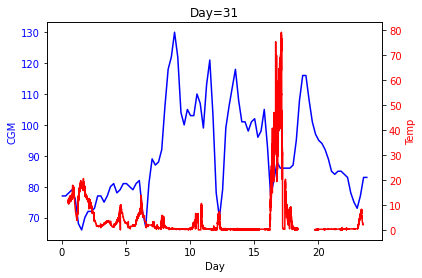

<class 'numpy.ndarray'>


In [87]:
days=df['Date']
days=days.values.tolist()
days=np.asarray(days,dtype=int)

days=set(days)
days=list(days)
days.sort()
#The data is noisy in the first and last days, so we dismiss them
days.remove(30)#first day and noisy
days.remove(40)#Partial E4
days.remove(41)#No E4
days.remove(42)#the CGM reading is super low
days.remove(43)#CGM is noisy
days = days[0:days.index(44)] #end of study

for day in days:
    fig, ax1 = plt.subplots ()
    ax2 = ax1.twinx ()

    inquery=df[df['Date']==day]
    inquery=inquery[inquery['Parameter']=='CGM']

    x=inquery['Time']
    x=x.values.tolist()
    x=np.asarray(x,dtype=float)
    y=inquery['Value']
    y=y.values.tolist()
    y=np.asarray(y,dtype=float)
    # f = interp1d (x, y)
    xnew=np.arange(0.5*3600,23.5*3600,1)
    # cgmNew=f(xnew)

    ax1.plot(x/3600,y,color='blue')
    ax1.tick_params (axis='y', labelcolor='blue')

    inquery=df[df['Date']==day]
    inquery=inquery[inquery['Parameter']=='EDA']

    x=inquery['Time']
    x=x.values.tolist()
    x=np.asarray(x,dtype=float)

    y=inquery['Value']
    y=y.values.tolist()
    y=np.asarray(y,dtype=float)
    f = interp1d (x, y,bounds_error=False, fill_value=0)
    varNew=f(xnew)

    ax2.plot(xnew/3600,varNew,color='red')
    ax2.tick_params (axis='y', labelcolor='red')

    ax1.set_ylabel('CGM')
    ax1.set_xlabel('Day')
    ax1.yaxis.label.set_color("blue")

    ax2.set_ylabel('Temp')
    ax2.yaxis.label.set_color("red")

    # plt.savefig(addressPrefix+'figure.jpg')
    plt.title("Day="+str(day))
    plt.show()
    varFlag=np.isnan(varNew)
    xNewModified=[]


    # corr, _ = pearsonr(cgmNew, varNew)
    # print('Pearsons correlation: %.3f' % corr)

    break